In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download Dataset

In [37]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

fatal: destination path 'small_dog_cat_dataset' already exists and is not an empty directory.


In [38]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1} # tao mot anh xa label
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (227, 227))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)

    return sample # image, label

In [39]:
# Tao trasform gom cac chuoi bien doi
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()
    # chuyen doi du lieu tu numpy array sang Pytorch Tensor
    return (image, label)

In [40]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms.Compose([convertToTensor()]))

In [41]:
def show_images(transformed_train_data, row, col):
    plt.figure(figsize=(10, 5))
    for i in range(1, row * col + 1):
        plt.subplot(row, col, i)
        plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[i]), cv2.COLOR_BGR2RGB), (224, 224)))
        plt.axis('off')
    plt.tight_layout()
    plt.show()


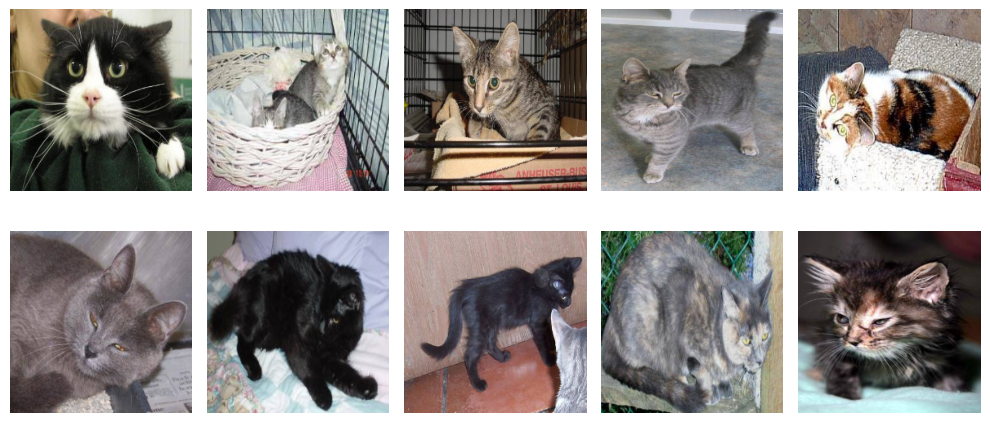

In [42]:
col = 5
row = 2
show_images(transformed_train_data, row, col)

In [43]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# AlexNet

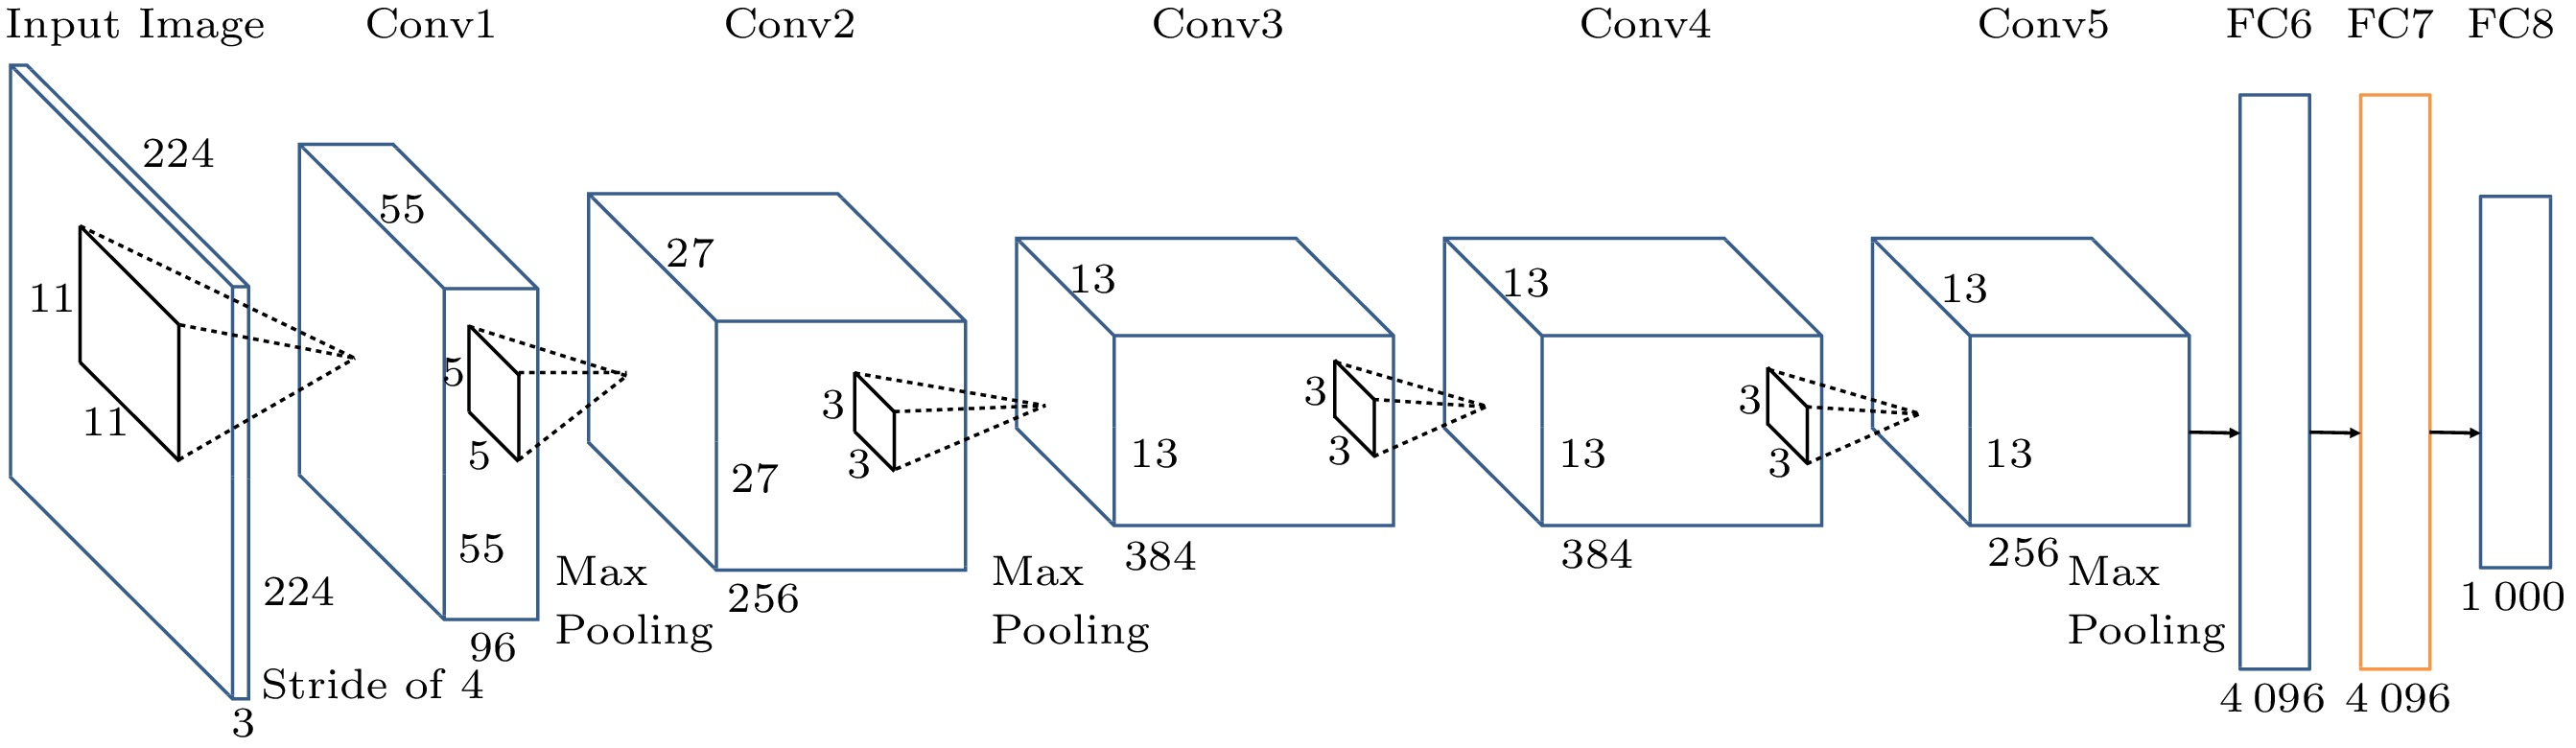

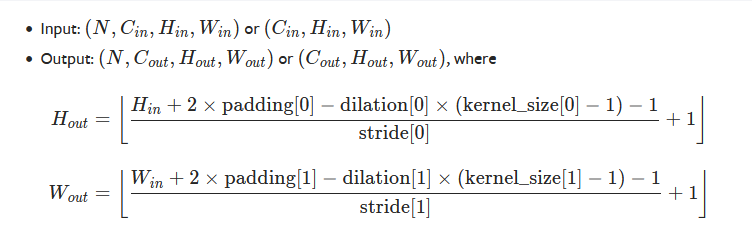

In [44]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
            # input size should be: (b x 3 x 227 x 227)
            # because the image with size 224 pixels, but the dimentios after 
            # first convolution layer do not lead to 55 x 55
        self.features_extractor = nn.Sequential(
            ## convolutional layers 1
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), # (b x 96 x 55 x 55)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 96 x 27 x 27)
            # convolutional layers 2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),# (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 256 x 13 x 13)
            # convolutional layers 3
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), # (b x 384 x 13 x 13)
            nn.ReLU(),
            # convolutional layers 4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), # (b x 384 x 13 x 13)
            nn.ReLU(),
            # convolutional layers 5
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2) # (b x 256 x 6 x 6)
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        x = self.features_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x

In [45]:
model = AlexNet(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train

In [46]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    #plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

Epochs: 0, Train_loss: 6.443226225792416, Valid_loss: 0.6931859254837036, Train_accuracy: 50.0, Valid_accuracy: 50.0
Epochs: 1, Train_loss: 0.6935700566049606, Valid_loss: 0.6932190437065927, Train_accuracy: 50.0, Valid_accuracy: 50.0
Epochs: 2, Train_loss: 0.693238931988913, Valid_loss: 0.6931542252239428, Train_accuracy: 50.0, Valid_accuracy: 50.0
Epochs: 3, Train_loss: 0.6932931996527172, Valid_loss: 0.6931641509658412, Train_accuracy: 50.0, Valid_accuracy: 50.0
Epochs: 4, Train_loss: 0.6934455179032826, Valid_loss: 0.6931465770068922, Train_accuracy: 50.0, Valid_accuracy: 50.0


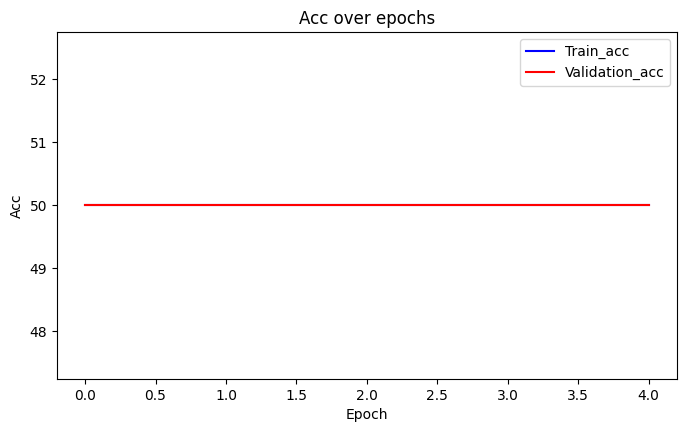

In [47]:
model, optimizer, _ = training_loop(model, loss_fn, optimizer, train_data_loader, test_data_loader, 5, device)
